# Identifying country names from incomplete house addresses with model explainability

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc">
<ul class="toc-item">
<li><span><a href="#Introduction" data-toc-modified-id="Introduction-1">Introduction</a></span></li>
<li><span><a href="#Prerequisites" data-toc-modified-id="Prerequisites-2">Prerequisites</a></span></li>
<li><span><a href="#Imports" data-toc-modified-id="Imports-3">Imports</a></span></li>
<li><span><a href="#Data-preparation" data-toc-modified-id="Data-preparation-4">Data preparation</a></span></li>
<li><span><a href="#TextClassifier-model" data-toc-modified-id="TextClassifier-model-5">TextClassifier model</a></span></li>
<ul class="toc-item">
<li><span><a href="#Load-model-architecture" data-toc-modified-id="Load-model-architecture-5.1">Load model architecture</a></span></li>
<li><span><a href="#Model-training" data-toc-modified-id="Model-training-5.2">Model training</a></span></li>    
<li><span><a href="#Validate-results" data-toc-modified-id="Validate-results-5.3">Validate results</a></span></li>
<li><span><a href="#Model-metrics" data-toc-modified-id="Model-metrics-5.4">Model metrics</a></span></li>    
<li><span><a href="#Get-misclassified-records" data-toc-modified-id="Get-misclassified-records-5.5">Get misclassified records</a></span></li>
<li><span><a href="#Saving-the-trained-model" data-toc-modified-id="Saving-the-trained-model-5.6">Saving the trained model</a></span></li>
</ul>
<li><span><a href="#Model-inference" data-toc-modified-id="Model-inference-6">Model inference</a></span></li>
<li><span><a href="#Conclusion" data-toc-modified-id="Conclusion-7">Conclusion</a></span></li>
<li><span><a href="#References" data-toc-modified-id="References-8">References</a></span></li>
</ul></div>

# Introduction

[Geocoding](https://en.wikipedia.org/wiki/Geocoding) is the process of taking input text, such as an **address** or the name of a place, and returning a **latitude/longitude** location for that place. In this notebook, we will be picking up a dataset consisting of incomplete house addresses from 10 countries. We will build a classifier using `TextClassifier` class of `arcgis.learn.text` module to predict the country for these incomplete house addresses. 

The house addresses in the dataset consist of text in multiple languages like English, Japanese, French, Spanish, etc. The dataset is a small subset of the house addresses taken from [OpenAddresses data](http://results.openaddresses.io/) 

**A note on the dataset**
- The data is collected around 2020-05-27 by [OpenAddresses](http://openaddresses.io).
- The data licenses can be found in `data/country-classifier/LICENSE.txt`.

# Prerequisites

- Data preparation and model training workflows using arcgis.learn have a dependency on [transformers](https://huggingface.co/transformers/v3.0.2/index.html). Refer to the section **"Install deep learning dependencies of arcgis.learn module"** [on this page](https://developers.arcgis.com/python/guide/install-and-set-up/#Install-deep-learning-dependencies) for detailed documentation on the installation of the dependencies.

- **Labeled data**: For `TextClassifier` to learn, it needs to see documents/texts that have been assigned a label. Labeled data for this sample notebook is located at `data/country-classifier/house-addresses.csv`

- To learn more about how `TextClassifier` works, please see the guide on [Text Classification with arcgis.learn](https://developers.arcgis.com/python/guide/text-classification).

# Imports

In [1]:
import arcpy 

In [2]:
import os
import zipfile
import pandas as pd
from pathlib import Path
from arcgis.gis import GIS
from arcgis.learn import prepare_textdata
from arcgis.learn.text import TextClassifier

from collections import Counter

In [3]:
gis = GIS('home')

In [4]:
import transformers

In [5]:
transformers.__version__

'4.24.0'

# Data preparation

Data preparation involves splitting the data into training and validation sets, creating the necessary data structures for loading data into the model and so on. The `prepare_data()` function can directly read the training samples and automate the entire process.

<Item title:"country_classifier" type:Image Collection owner:api_data_owner>
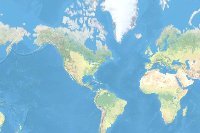

In [6]:
training_data = gis.content.get('ab36969cfe814c89ba3b659cf734492a')
training_data

In [7]:
filepath = training_data.download(file_name=training_data.name)
# filepath="C:\\Users\\kaj13232\\Documents\\Work\\NLP Notebook Samples\\country_classifier.zip"

In [8]:
with zipfile.ZipFile(filepath, 'r') as zip_ref:
    zip_ref.extractall(Path(filepath).parent)

In [9]:
DATA_ROOT = Path(os.path.join(os.path.splitext(filepath)[0]))

In [10]:
data = prepare_textdata(DATA_ROOT, "classification", train_file="house-addresses.csv", 
                        text_columns="Address", label_columns="Country", batch_size=64)

The `show_batch()` method can be used to see the training samples, along with labels.

In [11]:
data.show_batch(10)

this method is deprecated in favour of `Styler.hide(axis='index')`


source,target
"SN, RUA JORGE BAYERL, São Bento do Sul, SC, 89287-450",BR
"3, Rue des Hauts Pres, Doubs, 25300",FR
"8, Ooievaarsstraat, 2222",BE
"12, RUA 8, CASA 2, Goiânia, GO, 74430-250",BR
"SN, AVENIDA CASAS GRANDES, EJIDO CHIHUAHUA, Mexicali, Baja California",MX
"200, Aspen Rd, Birmingham, MI, 48009",US
"26, PRIVADA DEL CONDE, HERÓICA PUEBLA DE ZARAGOZA, Puebla, Puebla",MX
"102, Clos des Lauriers Roses, B007, 1140",BE
"8, POLK PLACE, BONNET BAY, NSW, 2226",AU
"S/N, LG INQUISICION-CORZANS, 36457",ES


In [12]:
data.show_batch(100)

this method is deprecated in favour of `Styler.hide(axis='index')`


source,target
"17, CL PINTOR SEGRELLE, 3760",ES
"BAIRRO BOA VISTA DOS BARBOSA, Bueno Brandão, MG, 37578-000",BR
"21, SANDERS CRESCENT, KINGS LANGLEY, NSW, 2147",AU
"1751, AVENIDA HUINOLO, LOS MOCHIS, Ahome, Sinaloa",MX
"12, Rue de l'Église, Villars-Saint-Georges, 25410",FR
"1344, CALLE MANUEL SALGADO, MEXICALI, Mexicali, Baja California",MX
"Tladistad, Moretele",ZA
"Kikvorschfontein, Elias Motsoaledi",ZA
"79-7, 細池町宮前",JP
"493, Avenue Marguerite Audoux, Saint-Raphaël, 83700",FR


# TextClassifier model

`TextClassifier` model in `arcgis.learn.text` is built on top of [Hugging Face Transformers](https://huggingface.co/transformers/v3.0.2/index.html) library. The model training and inferencing workflow are similar to computer vision models in `arcgis.learn`. 

Run the command below to see what backbones are supported for the text classification task.

In [13]:
print(TextClassifier.supported_backbones)

['BERT', 'RoBERTa', 'DistilBERT', 'ALBERT', 'FlauBERT', 'CamemBERT', 'XLNet', 'XLM', 'XLM-RoBERTa', 'Bart', 'ELECTRA', 'Longformer', 'MobileBERT', 'Funnel']


Call the model's `available_backbone_models()` method with the backbone name to get the available models for that backbone. The call to **available_backbone_models** method will list out only few of the available models for each backbone. Visit [this](https://huggingface.co/transformers/pretrained_models.html) link to get a complete list of models for each backbone.

In [14]:
print(TextClassifier.available_backbone_models("xlm-roberta"))

('xlm-roberta-base', 'xlm-roberta-large')


## Load model architecture

Invoke the `TextClassifier` class by passing the data and the backbone you have chosen. The dataset consists of house addresses in multiple languages like Japanese, English, French, Spanish, etc., hence we will use a [multi-lingual transformer backbone](https://huggingface.co/transformers/v3.0.2/multilingual.html) to train our model.

In [15]:
model = TextClassifier(data, backbone="xlm-roberta-base")

In [16]:
# model = TextClassifier(data)


In [17]:
# model.load("country-classifier")

## Model training

The `learning rate`[[1]](#References) is a **tuning parameter** that determines the step size at each iteration while moving toward a minimum of a loss function, it represents the speed at which a machine learning model **"learns"**. `arcgis.learn` includes a learning rate finder, and is accessible through the model's `lr_find()` method, that can automatically select an **optimum learning rate**, without requiring repeated experiments.

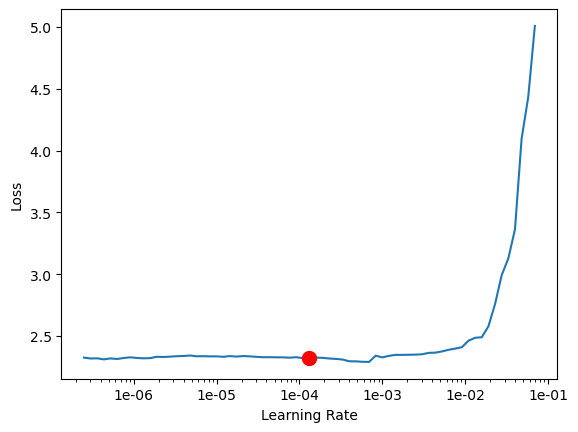

0.00013182567385564074

In [18]:
model.lr_find()

Training the model is an iterative process. We can train the model using its `fit()` method till the validation loss (or error rate) continues to go down with each training pass also known as an epoch. This is indicative of the model learning the task.

In [19]:
model.fit(epochs=6, lr=0.00013182567385564074)

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.091671,0.085025,0.975995,0.024005,03:17
1,0.107969,0.074215,0.976895,0.023105,03:18
2,0.067874,0.039669,0.985197,0.014803,03:10
3,0.039026,0.034880,0.986797,0.013203,03:15
4,0.026721,0.026260,0.988798,0.011202,03:13
5,0.012680,0.023542,0.989998,0.010002,03:11


## Validate results

Once we have the trained model, we can see the results to see how it performs.

In [20]:
model.show_results(15)

this method is deprecated in favour of `Styler.hide(axis='index')`


text,target,prediction
"1213, RUA BENJAMIN CONSTANT, ANDAR 02 APARTAMENTO 206 APARTAMENTO 205 APARTAMENTO 204 APARTAMENTO 203 APARTAMENTO 202, Blumenau, SC, 89035-100",BR,BR
"3A, AVENIDA QUINTA SUR ORIENTE (PROF. DOMITILA AGUERA), COMITÁN DE DOMÍNGUEZ, Comitán de Domínguez, Chiapas",MX,MX
"SN, RUA H CENTO E QUARENTA E CINCO, QUADRA 309 LOTE 16 CASA 2, Aparecida de Goiânia, GO, 74937-440",BR,BR
"104, CALLE BAJA CALIFORNIA, FRACCIONAMIENTO VALLE HUEJÚCAR (FRACCIONAMIENTO POPULAR), Calvillo, Aguascalientes",MX,MX
"1503, BOULEVARD LOS OLMECAS, FRACCIONAMIENTO CIUDAD OLMECA, Coatzacoalcos, Veracruz de Ignacio de la Llave",MX,MX
"SN, AVENIDA HÉROE DE NOCUPÉTARO ORIENTE, NOCUPÉTARO DE MORELOS, Nocupétaro, Michoacán de Ocampo",MX,MX
"SN, PRIVADA ALDAMA, DOLORES HIDALGO CUNA DE LA INDEPENDENCIA NACIONAL, Dolores Hidalgo Cuna de la Independencia Nacional, Guanajuato",MX,MX
"65, RUA ANA PATRICIA COELHO DE BITTENCOURT, BLOCO C APARTAMENTO 201, Criciúma, SC, 88811-216",BR,BR
"34, CALLE MELCHOR OCAMPO, COLONIA LÁZARO CÁRDENAS (1RA. SECCIÓN DEL RODEO), San Juan del Río, Querétaro",MX,MX
"SN, RUA HUMBERTO BANDEIRA DE MELO, BLOCO 14 ENTRADA 1 APARTAMENTO 201, Rio de Janeiro, RJ, 21832-020",BR,BR


### Test the model prediction on an input text

In [21]:
text = """1016, 8A, CL RICARDO LEON - SANTA ANA (CARTAGENA), 30319"""
print(model.predict(text))

('1016, 8A, CL RICARDO LEON - SANTA ANA (CARTAGENA), 30319', 'ES', 0.9999511241912842)


## Model Explainability using SHAP

To understand how the model works and individual token contribution, we use Shapley Additive Explanations (SHAP) on the model.

[Shapley Additive Explanations (SHAP)](https://github.com/slundberg/shap) values is a method for explaining the predictions of machine learning models. In the context of NLP, SHAP values can be used to understand how input features (or words in our case) influences the prediction of a model for a specific instance.
 
To get explanations of **single instances** - we pass a single address to the `predict()` function the parameter `explain` set to True

In [22]:
text = """1016, 8A, CL RICARDO LEON - SANTA ANA (CARTAGENA), 30319"""
print(model.predict(text, explain=True))

('1016, 8A, CL RICARDO LEON - SANTA ANA (CARTAGENA), 30319', 'ES', 0.9999511241912842)


In the plot above, when we hover the mouse over an output class, we get the explanation for that output class. When we click an output class name then that class remains the focus of the explanation visualization until we click another class.

The base value is what the model outputs when the entire input text is masked (set to a constant or null), while $f_{output class}(inputs)$ is the output of the model for the full original input. The SHAP values explain in an addive way how the impact of unmasking each word changes the model output from the base value (where the entire input is masked) to the final prediction value.

The features that were important to making the prediction for this observation are shown in red and blue, with red representing features that pushed the model score higher, and blue representing features that pushed the score lower. Features that had more of an impact on the score are located closer to the dividing boundary between red and blue, and the size of that impact is represented by the size of the bar.

 
To get explanations of **multiple instances** - we pass a list of addresses to the `predict()` function the parameter `explain` set to True and the parameter `explain_index` set as the list of indices we want to explain.

In [23]:
text = ["""22, BULKARA ROAD, BELLEVUE HILL, NSW, 2023""",
"""30, RUA BOM MILAGRE, São Luís, MA, 65000-000""",
"""193, STAFFORD DRIVE, Wheeling, 60090""",
"""2375-3, 周東町上久原""",
"""35, CL CANCHUELA, 5400"""]
print(model.predict(text, explain=True,explain_index=[1,3]))

[('22, BULKARA ROAD, BELLEVUE HILL, NSW, 2023', 'AU', 0.9999783039093018), ('30, RUA BOM MILAGRE, São Luís, MA, 65000-000', 'BR', 0.9999797344207764), ('193, STAFFORD DRIVE, Wheeling, 60090', 'US', 0.9995813965797424), ('2375-3, 周東町上久原', 'JP', 0.9999904632568359), ('35, CL CANCHUELA, 5400', 'ES', 0.9999456405639648)]


In the plot above, we can see the explanation for that multiple instances selected one below the other, as well the predicted class for each input instance listed in the final output shown.

## Model metrics

To get a sense of how well the model is trained, we will calculate some important metrics for our `text-classifier` model. First, to find how accurate[[2]](#References) the model is in correctly predicting the classes in the dataset, we will call the model's `accuracy()` method.

In [24]:
model.accuracy()

0.99

Other important metrics to look at are Precision, Recall & F1-measures [[3]](#References). To find `precision`, `recall` & `f1` scores per label/class we will call the model's `metrics_per_label()` method.

In [25]:
model.metrics_per_label()

,Precision_score,Recall_score,F1_score,Support
AU,1.0000,1.0000,1.0000,1000.0
BE,0.9990,0.9990,0.9990,1000.0
BR,1.0000,1.0000,1.0000,1000.0
CA,0.9373,0.9710,0.9538,1000.0
ES,0.9990,1.0000,0.9995,1000.0
FR,0.9990,0.9990,0.9990,1000.0
JP,1.0000,1.0000,1.0000,1000.0
MX,0.9990,1.0000,0.9995,1000.0
US,0.9698,0.9329,0.9510,998.0
ZA,1.0000,1.0000,1.0000,1000.0


## Get misclassified records

Its always a good idea to see the cases where your model is not performing well. This step will help us to:
- Identify if there is a problem in the dataset.
- Identify if there is a problem with text/documents belonging to a specific label/class.  
- Identify if there is a class imbalance in your dataset, due to which the model didn't see much of the labeled data for a particular class, hence not able to learn properly about that class.

To get the **misclassified records** we will call the model's `get_misclassified_records` method.

In [26]:
misclassified_records = model.get_misclassified_records()

In [27]:
Counter(misclassified_records["Prediction"])

Counter({'CA': 65, 'US': 29, 'FR': 1, 'BE': 1, 'ES': 1, 'MX': 1})

In [28]:
Counter(misclassified_records["Target"])

Counter({'US': 67, 'CA': 29, 'FR': 1, 'BE': 1})

In [29]:
misclassified_records.style.set_table_styles([dict(selector='th', props=[('text-align', 'left')])])\
        .set_properties(**{'text-align': "left"}).hide_index()

this method is deprecated in favour of `Styler.hide(axis='index')`


Address,Target,Prediction
"4404, Mark St, Bellevue",US,CA
30335,US,CA
"59, LESLIE ST",US,CA
"6735, WESTLAKE AVE",US,CA
"903, LAWRENCE GRASSI RIDGE",CA,US
"875, PASO DR",US,CA
"5312, AUDREY ST",US,CA
"6360, VIA MARIA, La Jolla, 92037",US,FR
"2109, OAKRIDGE CR",CA,US
"1015, CLINTON ST",US,CA


## Saving the trained model

Once you are satisfied with the model, you can save it using the save() method. This creates an Esri Model Definition (EMD file) that can be used for inferencing on unseen data.

In [30]:
model.save("country-classifier-17thfeb-xlm -acc99")

Computing model metrics...


WindowsPath('C:/Users/kaj13232/Documents/Work/NLP Notebook Samples/models/country-classifier-17thfeb-xlmroberta-acc99')

# Model inference

The trained model can be used to classify new text documents using the predict method. This method accepts a string or a list of strings to predict the labels of these new documents/text.

In [31]:
text_list = data._train_df.sample(15).Address.values
result = model.predict(text_list)

df = pd.DataFrame(result, columns=["Address", "CountryCode", "Confidence"])

df.style.set_table_styles([dict(selector='th', props=[('text-align', 'left')])])\
        .set_properties(**{'text-align': "left"}).hide_index()

this method is deprecated in favour of `Styler.hide(axis='index')`


Address,CountryCode,Confidence
"SN, CALLE FRANCISCO SARABIA, SAN GABRIEL CHILAC, San Gabriel Chilac, Puebla",MX,0.999985
"5-5, 池田谷町二丁目",JP,0.999990
"7632, rue Lajeunesse",CA,0.999094
"35, Graaf d'Ursellaan, 22, 8301",BE,0.999928
"3, Rue du Rugunay, Locquirec, 29241",FR,0.999959
"149, Bertrandfosse, Plailly, 60128",FR,0.999959
"134, Rue Jean Baptiste Rouam-sim, Fort-de-France, 97200",FR,0.999952
"99, JONES STREET, UNIT 295, ULTIMO, NSW, 2007",AU,0.999979
"1, SHOPPERS LANE, TAYLORS LAKES, VIC, 3038",AU,0.999978
"2, WALLACE STREET, MOUNT BEAUTY, VIC, 3699",AU,0.999978


In [32]:


Counter(data._train_df["Country"])

Counter({'ES': 9000,
         'FR': 9000,
         'BR': 9000,
         'MX': 9000,
         'AU': 9000,
         'ZA': 9000,
         'CA': 9000,
         'JP': 9000,
         'BE': 9000,
         'US': 8995})

# Conclusion

In this notebook, we have built a text classifier using `TextClassifier` class of `arcgis.learn.text` module. The dataset consisted of house addresses of 10 countries written in languages like English, Japanese, French, Spanish, etc. To achieve this we used a [multi-lingual transformer backbone](https://huggingface.co/transformers/v3.0.2/multilingual.html) like `XLM-RoBERTa` to build a classifier to predict the country for an input house address. 

# References

[1] [Learning Rate](https://en.wikipedia.org/wiki/Learning_rate)

[2] [Accuracy](https://en.wikipedia.org/wiki/Accuracy_and_precision)

[3] [Precision, recall and F1-measures](https://scikit-learn.org/stable/modules/model_evaluation.html#precision-recall-and-f-measures)